## Init

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.interpolate as interp
from emu_like.datasets import DataCollection
from emu_like.ffnn_emu import FFNNEmu
import emu_like.spectra

def get_y(emu, x):
    return np.array([emu.eval(xp) for xp in x])

def get_diff(emu, x, y):
    y_emu = get_y(emu, x)
    diff =  y_emu/y-1
    return diff

def get_derived(emu, data):
    derived = {
         'y_emu': get_y(emu, data.x),
         'diff': get_diff(emu, data.x, data.y),
         'diff_train': get_diff(emu, data.x_train, data.y_train),
         'diff_test': get_diff(emu, data.x_test, data.y_test),
    }
    return derived

def get_idx_max_diff(diff):
    idx = np.argmax(np.mean(diff**2., axis=1))
    return idx

def get_ref(emu, data, idx_max):
    if emu.y_model.spectra[0].is_pk:
        z = data.x[idx_max, 0]
        ref = interp.make_splrep(emu.y_model.z_array, emu.y_model.y_ref[0][0].T, s=0)(z)
    else:
        ref = emu.y_model.y_ref[0][0]
    return ref

2025-07-26 11:05:59.566551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 11:05:59.570569: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 11:05:59.581953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753520759.599974 3343084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753520759.605409 3343084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753520759.619499 3343084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Settings

In [2]:
root_sample = '../output/lcdm_2D/sample/1000'
root_train = '../output/lcdm_2D/train/1000'

spectrum = 'f_m'

In [3]:
# Load dataset
data = DataCollection().load(path=root_sample).get_one_y_dataset(spectrum)

data.train_test_split(
    frac_train=0.9,
    seed=1543)


In [4]:
# Load one emulator
emu_old = FFNNEmu().load(os.path.join(root_train, spectrum))

derived_old = get_derived(emu_old, data)

2025-07-26 11:06:48.529658: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Build new emulator

In [5]:
data.rescale(
    rescale_x = 'MinMaxScaler',
    rescale_y = 'MinMaxCommonScaler')

In [6]:
params_emu = {
    'activation': 'relu',
    'neurons_hidden': [40, 40],
    'batch_normalization': False,
    'dropout_rate': 0.,
    'batch_size': 32,
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'want_output_layer': True,
    'data_n_x': data.n_x,
    'data_n_y': data.n_y,
}

emu = FFNNEmu()

emu.build(params_emu, verbose=True)

[info] Building FFNN architecture
----> Activation function: relu
----> Dropout rate: 0.0
----> Optimizer: adam
----> Loss function: mean_squared_error


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 40)               │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 40)               │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 600)              │        24,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,360 (102.97 KB)

 Trainable params: 26,360 (102.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 104: early stopping
Restoring model weights from the end of the best epoch: 74.


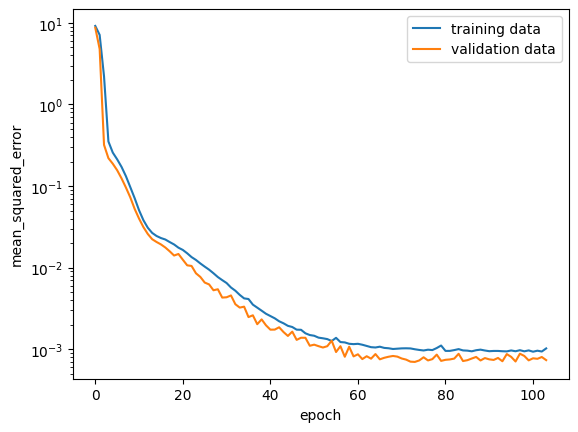

In [ ]:
emu.train(
    data,
    epochs=2000,
    learning_rate=1.e-3,
    patience=100,
    get_plots=True,
    )

Epoch 140: early stopping
Restoring model weights from the end of the best epoch: 110.


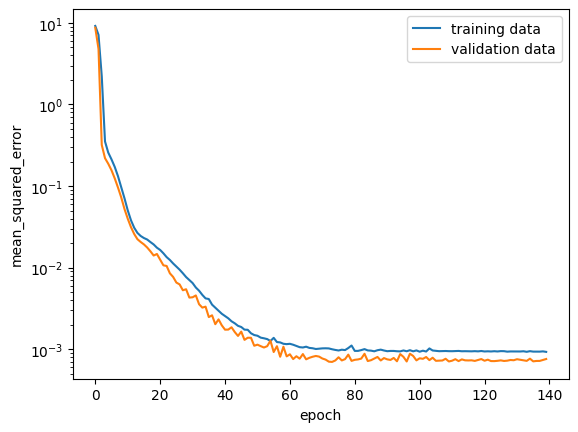

In [ ]:
emu.train(
    data,
    epochs=2000,
    learning_rate=1.e-4,
    patience=100,
    get_plots=True,
    )

Epoch 191: early stopping
Restoring model weights from the end of the best epoch: 161.


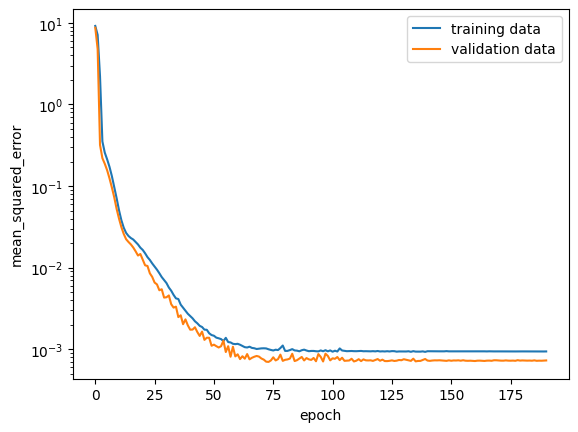

In [ ]:
emu.train(
    data,
    epochs=2000,
    learning_rate=1.e-5,
    patience=100,
    get_plots=True,
    )

In [10]:
derived = get_derived(emu, data)

## Plots

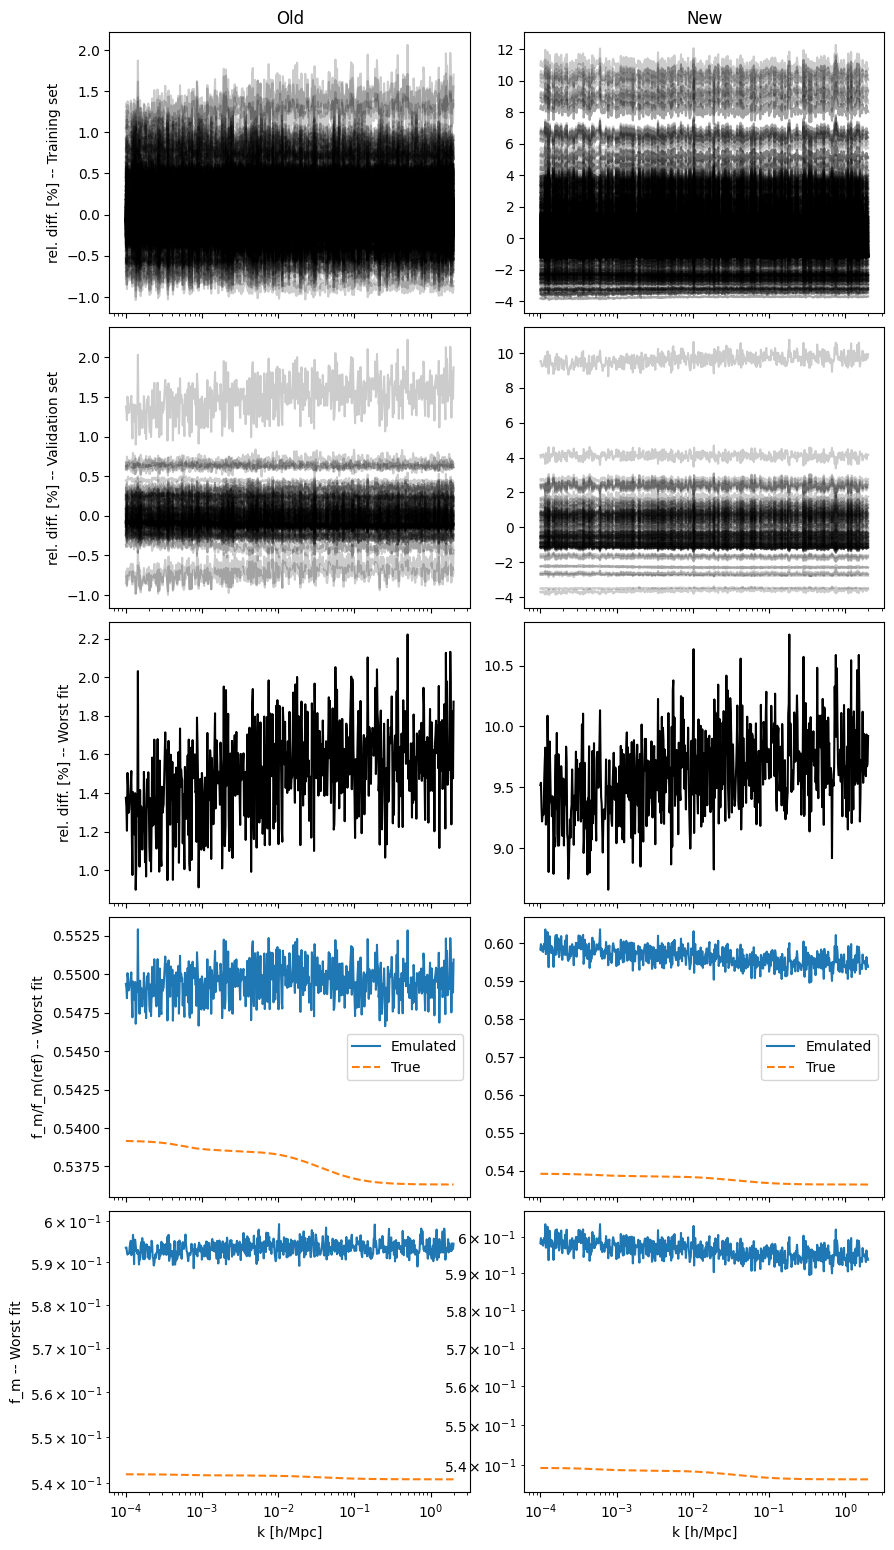

In [11]:
x_old = emu_old.y_model.k_ranges[0]
x = emu.y_model.k_ranges[0]

idx_max_old = get_idx_max_diff(derived_old['diff'])
idx_max = get_idx_max_diff(derived['diff'])


fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10., 20.), sharex=True, squeeze=False)

ax[0, 0].set_ylabel('rel. diff. [%] -- Training set')
ax[1, 0].set_ylabel('rel. diff. [%] -- Validation set')
ax[2, 0].set_ylabel('rel. diff. [%] -- Worst fit')
ax[3, 0].set_ylabel('{}/{}(ref) -- Worst fit'.format(spectrum, spectrum))
ax[4, 0].set_ylabel('{} -- Worst fit'.format(spectrum))

ax[0, 0].set_title('Old')
ax[0, 1].set_title('New')

ax[-1, 0].set_xlabel('k [h/Mpc]')
ax[-1, 1].set_xlabel('k [h/Mpc]')

ax[-1, 0].set_xscale('log')
ax[-1, 1].set_xscale('log')

ax[-1, 0].set_yscale('log')
ax[-1, 1].set_yscale('log')

# Training set
ax[0, 0].plot(x_old, derived_old['diff_train'].T*100., 'k-', alpha=0.2)
ax[0, 1].plot(x, derived['diff_train'].T*100., 'k-', alpha=0.2)

# Validation set
ax[1, 0].plot(x_old, derived_old['diff_test'].T*100., 'k-', alpha=0.2)
ax[1, 1].plot(x, derived['diff_test'].T*100., 'k-', alpha=0.2)

# Worst fit, rel diff
ax[2, 0].plot(x_old, derived_old['diff'][idx_max_old]*100., 'k-')
ax[2, 1].plot(x, derived['diff'][idx_max_old]*100., 'k-')

# Worst fit, P/P_ref
ax[3, 0].plot(x_old, derived_old['y_emu'][idx_max_old], label='Emulated')
ax[3, 0].plot(x_old, data.y[idx_max], '--', label='True')
ax[3, 0].legend()
ax[3, 1].plot(x, derived['y_emu'][idx_max], label='Emulated')
ax[3, 1].plot(x, data.y[idx_max], '--', label='True')
ax[3, 1].legend()

# Worst fit, P
ax[4, 0].plot(x_old, get_ref(emu_old, data, idx_max_old)*derived['y_emu'][idx_max_old])
ax[4, 0].plot(x_old, get_ref(emu_old, data, idx_max_old)*data.y[idx_max_old], '--')
ax[4, 1].plot(x, get_ref(emu, data, idx_max)*derived['y_emu'][idx_max])
ax[4, 1].plot(x, get_ref(emu, data, idx_max)*data.y[idx_max], '--')


plt.subplots_adjust(bottom=0.15, hspace=0.05, wspace=0.15)
plt.show()

In [12]:
print('Old')
for var, val in zip(data.x_names, data.x[idx_max_old]):
    print('{} = {}'.format(var, val))
print('New')
for var, val in zip(data.x_names, data.x[idx_max]):
    print('{} = {}'.format(var, val))

Old
z_pk = 0.022873902312929115
h = 0.8909748929803329
New
z_pk = 0.01767065237670453
h = 0.552062955398391


In [13]:
np.mean(derived_old['diff'][idx_max_old]**2.)

np.float64(0.00023153124947335253)

In [14]:
np.mean(derived['diff'][idx_max]**2.)

np.float64(0.011916033388587011)